In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier
import math
import scipy.stats as stats
import statsmodels.api as sm
import pylab as pl

In [2]:
alldata = pd.read_csv('allmodel_denovo.csv', sep = '\t')

In [28]:
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']

# the features for comparison (to other supervised score)
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score']

x_column  = original_column + ['M-CAP_score', 'REVEL_score']
y_column = 'source'


originaldata = alldata[alldata['source'] == 0] #46787
denovo = alldata[alldata['source'] ==1] #5985

y = originaldata.loc[:,[y_column]].values.flatten()
#X = originaldata.loc[:,x_column]
X = originaldata.loc[:,original_column]


#X_denovo = denovo.loc[:,x_column]
X_denovo = denovo.loc[:,original_column]
y_denovo = denovo.loc[:,[y_column]].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
#Xtrain_denovo, Xtest_denovo, ytrain_denovo, ytest_denovo = train_test_split(X_denovo,y_denovo, test_size = 0.3, random_state = 42)


X_train = pd.concat([X_train, X_denovo], join= 'inner')
y_train = np.concatenate((y_train, np.full((1,5985),1).flatten())).flatten()

# X_test = pd.concat([X_test, Xtest_denovo], join= 'inner')
# y_test = np.concatenate((y_test, np.full((1,1796),1).flatten())).flatten()

regression = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(X_train, y_train)

y_hat = regression.predict_proba(X_test)[:,1]

In [5]:
X_train.shape  #38735
X_test.shape   #14037

(38735, 32)

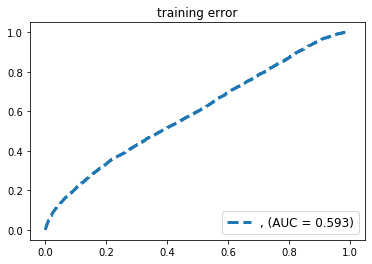

In [29]:
y_train_hat = regression.predict_proba(X_train)[:,1]
drawROC(y_train, y_train_hat, title = 'training error', lastone = True)

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


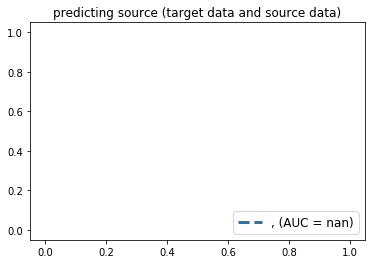

In [6]:
#X_train, X_test, y_train, y_test, y_hat, regression = splitNfit(alldata, x_column, y_column, testsize = 0.3)
drawROC(y_test, y_hat, title = 'predicting source (target data and source data)', lastone = True)


In [31]:
coef_overall = regression.coef_.flatten()

coefficient = pd.DataFrame({'regression':coef_overall}, index = original_column)
coefficient['regression'].sort_values()

PROVEN_pred      -0.457706
MA_pred          -0.387346
PredSSH          -0.187177
phyloP_pri       -0.165607
PROVEN_score     -0.133456
LRT_pred         -0.115068
SIFT_pred        -0.108549
PredSSE          -0.093273
HMMRelEntropy    -0.091590
phyloP_ver       -0.080228
Grantham         -0.071888
PredBFactorS     -0.057148
PredBFactorF     -0.055428
PredSSC          -0.049617
PredBFactorM     -0.045120
LRT_omega        -0.010749
SIFT_score        0.014778
SLR_score         0.035484
MA_score          0.036001
phyloP_mam        0.040178
RNA_seq           0.041145
dscore            0.059850
HMMEntropy        0.129350
UNEECON           0.217199
PredRSAI          0.366697
PredRSAB          0.392681
PredRSAE          0.694242
PredStabilityM    1.004926
PredStabilityL    2.318495
PredStabilityH    2.334553
Name: regression, dtype: float64

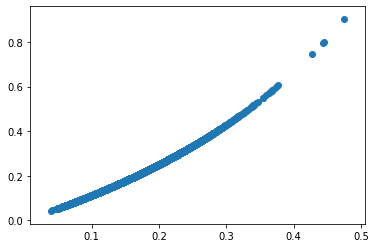

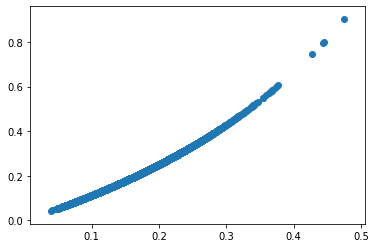

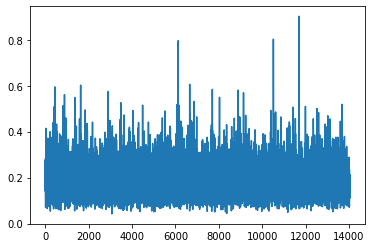

14037

In [32]:
instance_weight = y_hat/(1-y_hat)
plt.scatter(y_hat, instance_weight)
plt.show()
instance_weight_round = np.around(instance_weight)
plt.scatter(y_hat, instance_weight)
plt.show()
plt.plot(instance_weight)
plt.show()
np.count_nonzero(instance_weight)

In [9]:
#compute class weight
originaldata = alldata[alldata['source'] == 0] #46787
denovo = alldata[alldata['source'] ==1] #5985

classweight = {0:46787/(46787+5985), 1:5985/(46787+5985)}

In [33]:
# test with float

# training data here

X = originaldata.loc[:,x_column]
y = originaldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

denovo = pd.read_csv('denovo_data.csv', sep = '\t')
X_test_denovo = denovo.loc[:,x_column]
y_test_denovo = denovo.loc[:,['result']].values


# fit denovo data using training data with instance weight
transfer_LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs', class_weight = classweight).fit(Xtest, ytest, sample_weight = instance_weight)
y_hat_denovo = transfer_LGR.predict_proba(X_test_denovo)[:,1]

LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(Xtest, ytest)
y_hat_denovo_ori = LGR.predict_proba(X_test_denovo)[:,1]

LGR2 = LogisticRegression(random_state = 42 , solver = 'lbfgs',max_iter = 150).fit(Xtrain, ytrain)
y_hat_denovo_ori2 = LGR2.predict_proba(X_test_denovo)[:,1]

In [11]:
# delete later
# training data here

# round data
X = originaldata.loc[:,x_column]
y = originaldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

denovo = pd.read_csv('denovo_data.csv', sep = '\t')
X_test_denovo = denovo.loc[:,x_column]
y_test_denovo = denovo.loc[:,['result']].values


# fit denovo data using training data with instance weight
transfer_LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs', class_weight = classweight).fit(Xtest, ytest, sample_weight = instance_weight_round.astype(int))
y_hat_denovo = transfer_LGR.predict_proba(X_test_denovo)[:,1]

LGR = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(Xtest, ytest)
y_hat_denovo_ori = LGR.predict_proba(X_test_denovo)[:,1]

LGR2 = LogisticRegression(random_state = 42 , solver = 'lbfgs',max_iter = 150).fit(Xtrain, ytrain)
y_hat_denovo_ori2 = LGR2.predict_proba(X_test_denovo)[:,1]

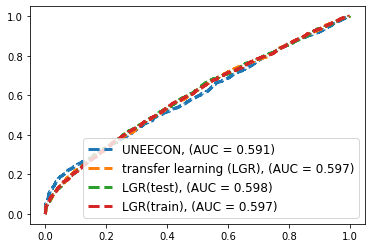

In [37]:
drawROC(y_test_denovo, denovo['UNEECON'], label = 'UNEECON')
drawROC(y_test_denovo, y_hat_denovo, label = 'transfer learning (LGR)')
drawROC(y_test_denovo, y_hat_denovo_ori, label = 'LGR(test)')

drawROC(y_test_denovo, y_hat_denovo_ori2, label = 'LGR(train)', lastone = True)


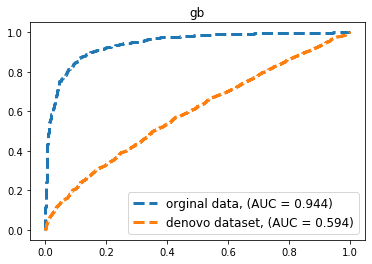

In [13]:
# to reproduce the result of original model

def split(df, Xname, Yname, testsize = 0.1):
    y = df.loc[:,[Yname]].values
    y = y.flatten()
    X = df.loc[:,Xname]
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest)


Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = split(originaldata, x_column, 'result')


denovo = pd.read_csv('denovo_data.csv', sep = '\t')
X_test_denovo = denovo.loc[:,x_column]
y_test_denovo = denovo.loc[:,['result']].values

gb = fitting_gb(Xtrain, ytrain, Xtest, ytest, 0.1, 3, 150)
denovo_gb = fitting_gb(Xtrain, ytrain, X_test_denovo, y_test_denovo, 0.1, 3, 150)
drawROC(gb[0], gb[1], label = 'orginal data')
drawROC(denovo_gb[0], denovo_gb [1], label = 'denovo dataset', lastone = True, title = 'gb')

In [14]:
def enrichment(df, portion, features, log = True, plot = True):
    num = int(df.shape[0]*portion*0.01)
    oddsratios = []
    errors = []
    for i in features:
    
        df[i] = pd.to_numeric(df[i])
        top = np.sum(df.nlargest(num,i)['result']) 
        array1 = [top, num-top]
              
        tail = np.sum(df.nsmallest(df.shape[0]-num,i)['result'])
        array2 = [tail, df.shape[0]-num-tail]

        
        result = sm.stats.Table2x2(np.asarray([array1, array2])).oddsratio
    
        if(log == True):
            result = math.log2(result)
            #result = math.log(result)
        #print(result)
        oddsratios.append(result)

        # check
        #print((top/(num-top))/(tail/(df.shape[0]-num-tail)))
        

        # change of base
        error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))* math.log2(math.e)
        #error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))
        errors.append(error)
     
    # Build the plot
    if(plot == True):
        fig, sub = plt.subplots(figsize=(18, 7))
    
        sub.bar(features, oddsratios,yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=5)
   
        plt.ylabel("log2 enrichment of proband denovo data")
    
        plt.title("enrichment test, enrichment level = %s percent"%portion)
    
        plt.show()
            
    return(oddsratios, np.asarray([array1,array2]))    


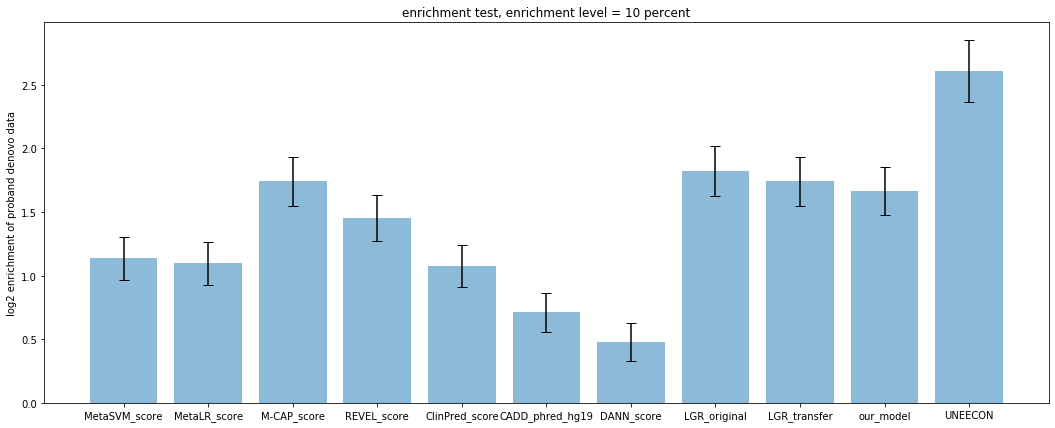

([1.1358827463279577,
  1.096848432033386,
  1.7408660086950296,
  1.4500995490997357,
  1.0775634858238041,
  0.7117291887539086,
  0.4787694421295965,
  1.8199683038704768,
  1.7408660086950296,
  1.6646973819800648,
  2.606006297511022],
 array([[ 559,   39],
        [3781, 1606]]))

In [39]:
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19','DANN_score']

denovo['LGR_original'],denovo['LGR_transfer'],denovo['our_model'] = [y_hat_denovo_ori,y_hat_denovo, denovo_gb[1]]

features = features + ['LGR_original', 'LGR_transfer', 'our_model', 'UNEECON']

enrichment(denovo,10, features)

In [40]:
denovo[['our_model','LGR_transfer']]

,our_model,LGR_transfer
0,0.950581,0.392566
1,-1.330749,0.032608
2,-1.946681,0.031078
3,-2.952964,0.013010
4,-1.534187,0.056567
...,...,...
5980,-0.058236,0.144618
5981,-2.678528,0.029490
5982,-1.155926,0.072836
5983,-2.812787,0.029532


In [17]:
print(enrichment(denovo, 10, ['LGR_transfer'], plot = False))
enrichment(denovo, 10, ['our_model'], plot = False)

([1.615421041913904], array([[ 527,   71],
       [3813, 1574]]))


([1.6646973819800648], array([[ 529,   69],
        [3811, 1576]]))

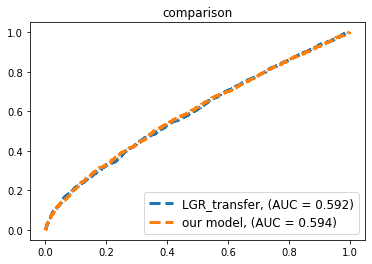

In [241]:
drawROC(y_test_denovo, y_hat_denovo, label = 'LGR_transfer')
drawROC(denovo_gb[0], denovo_gb [1], label = 'our model', lastone = True, title = 'comparison')

In [176]:
ytest.shape #15832
np.sum(ytest) # 9721

2788

In [179]:
ytrain.shape

(37476,)

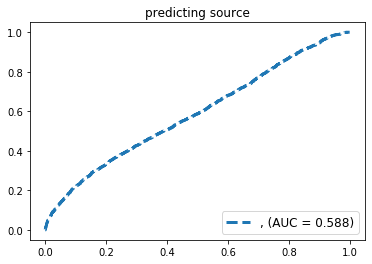

In [23]:
# DONT USE M-CAP AND REVEL as features

X_train, X_test, y_train, y_test, y_hat, regression = splitNfit(alldata, original_column, y_column, testsize = 0.3)
drawROC(y_test, y_hat, title = 'predicting source', lastone = True)

[[13314   712]
 [ 1556   250]]


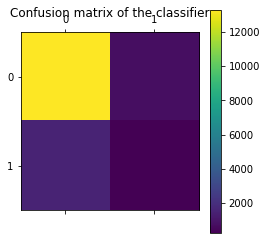

[[12732  1294]
 [ 1426   380]]


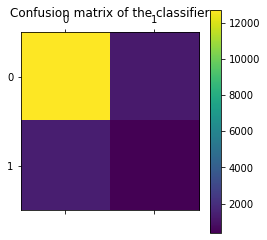

[[12103  1923]
 [ 1326   480]]


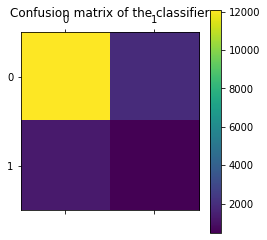

In [28]:
confusionmatrix(y_test, y_hat, 0.175 )
confusionmatrix(y_test, y_hat, 0.16 )  #chose 0.16 as cutoff
confusionmatrix(y_test, y_hat, 0.15 )

  


In [30]:
false_pos_loc = prediction_location(y_hat, y_test, 0.16)[4] #false_positive

new_train = X_test.iloc[np.r_[false_pos_loc[0]],:]
X = alldata.loc[:,x_column]
y = alldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

clinvar_result = ytest[np.r_[false_pos_loc[0]],]
new_y = clinvar_result

# train gb
Xtrain, Xtest, ytrain, ytest = train_test_split(new_train, new_y, test_size = 0.1, random_state = 42)    
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain, ytrain, test_size = 0.11, random_state = 42)
tuning(Xvalid, yvalid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
With score : 0.796

Grid scores on development set:

0.790 (+/-0.122) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.782 (+/-0.078) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.773 (+/-0.142) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.782 (+/-0.118) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.773 (+/-0.102) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.773 (+/-0.102) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.796 (+/-0.108) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.793 (+/-0.153) for {

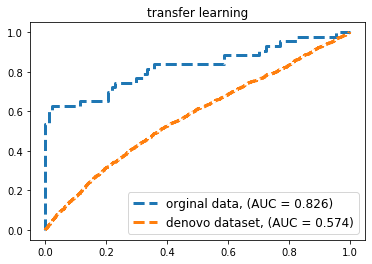

In [32]:
X_test_denovo = denovo.loc[:,original_column]
gb = fitting_gb(Xtrain, ytrain, Xtest, ytest, 0.1, 3, 100)
denovo_gb = fitting_gb(Xtrain, ytrain, X_test_denovo, y_test_denovo, 0.1, 3, 100)
drawROC(gb[0], gb[1], label = 'orginal data')
drawROC(denovo_gb [0], denovo_gb [1], label = 'denovo dataset', lastone = True, title = 'transfer learning')

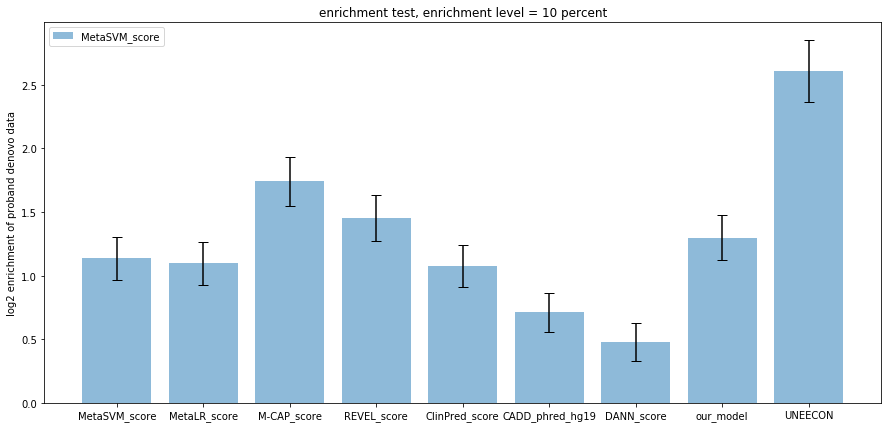

In [33]:
enrichment(denovo, 10, features) #2 as base